# Aprendizaje por refuerzo en robótica móvil

## Inteligencia Artificial
### Grado en Ingeniería Informática - Ingeniería del Software
### Curso 2023/2024
### Profesor: Ignacio Pérez Hurtado de Mendoza


El paquete de _Python_ [pymdptoolbox](https://github.com/sawcordwell/pymdptoolbox) proporciona un marco de trabajo para procesos de decisión de Markov.

El paquete proporciona tres módulos:
* El módulo _mdp_ es el que implementa los procesos de decisión de Markov y los algoritmos de iteración de valores y de políticas, entre otros.
* El módulo _util_ proporciona algunas funciones para comprobar la correcta descripción del proceso de decisión de Markov, como por ejemplo que la función de transición de cada acción aplicada a cada estado es una distribución de probabilidad (las probabilidades de los nuevos estados están en el intervalo $[0, 1]$ y suman $1$).
* El modulo _example_ proporciona algunos ejemplos.


In [1]:
import mdptoolbox.mdp as mdp

Los algoritmos para calcular una política óptima utilizan operaciones matriciales, por lo que también necesitaremos hacer uso del paquete [Numpy](https://numpy.org/).

In [2]:
import numpy as np

Se recomienda repasar el tema de clase sobre aprendizaje por refuerzo, tanto la parte teórica como práctica.

# Ejemplo de navegación en robótica móvil

En este ejemplo vamos a reproducir el ejemplo de MDP planteado en el capítulo 14 del libro *Probabilistic Robotics*

Tendremos una mapa definido por una matriz de ocupación y un goal, leeremos estos datos de un fichero en el que primeramente vendrán las coordenadas del goal y luego vendrá línea por línea la matriz de ocupación, en dónde 1 significa obstáculo y 0 significa libre.

In [388]:
# El siguiente código lee el goal y el mapa del fichero

def lee_mapa(fichero):
    with open(fichero,'r') as archivo:
        lineas = archivo.readlines()
    numeros = [float(numero) for numero in lineas[0].split()]
    lineas.pop(0)
    lineas.reverse()
    matriz = []
    for linea in lineas:
        fila = [int(caracter) for caracter in linea.strip()]
        matriz.append(fila)
    return np.array(matriz),(numeros[0],numeros[1])


In [389]:
# Descomentar solo el mapa con el que se quiera trabajar

#mapa,destino = lee_mapa("map.txt")
mapa,destino = lee_mapa("map2.txt")
#mapa,destino = lee_mapa("map3.txt")
print(mapa)
print(destino)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1]
 [1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
(17.0, 2.0)


Para visualizar el mapa, utilizaremos matplotlib, la siguiente función realiza la visualización del mapa. El goal se señala como un punto rojo.

In [390]:
import matplotlib.pyplot as plt
def visualiza_mapa():
    plt.figure(figsize=(len(mapa[0]), len(mapa)))
    plt.imshow(1-mapa, cmap='gray', interpolation='none')
    plt.xlim(-0.5, len(mapa[0]) - 0.5)
    plt.ylim(-0.5, len(mapa) - 0.5)
    plt.gca().add_patch(plt.Circle(destino,radius = 0.5,edgecolor = 'red', facecolor = 'red'))
   
    

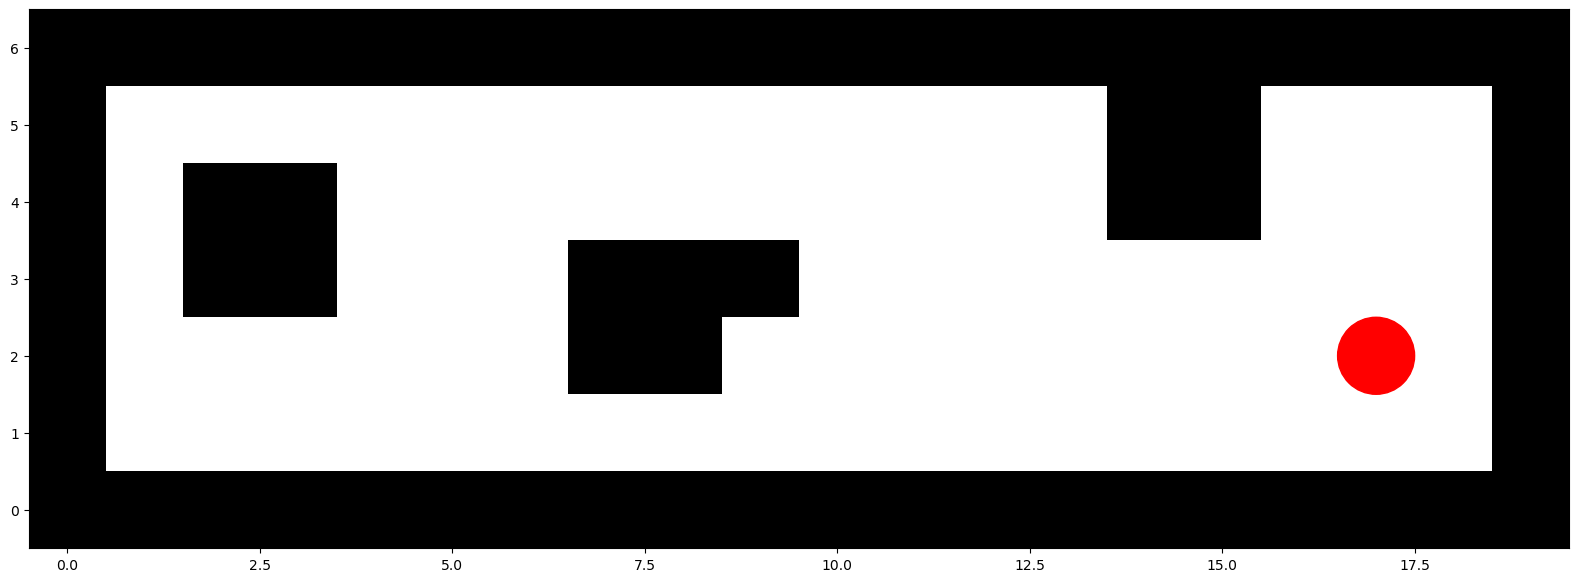

In [391]:
visualiza_mapa()


Los estados del problema serán las casillas del mapa (incluso las que tienen obstáculos), el siguiente código extrae los estados como una lista de tuplas (x,y)

In [392]:
nav_estados = []
for i in range(0,mapa.shape[1]):
    for j in range(0,mapa.shape[0]):
        nav_estados.append(tuple([i,j]))
nav_estados

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (8, 0),
 (8, 1),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (9, 0),
 (9, 1),
 (9, 2),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 6),
 (10, 0),
 (10, 1),
 (10, 2),
 (10, 3),
 (10, 4),
 (10, 5),
 (10, 6),
 (11, 0),
 (11, 1),
 (11, 2),
 (11, 3),
 (11, 4),
 (11, 5),
 (11, 6),
 (12, 0),
 (12, 1),
 (12, 2),
 (12, 3),
 (12, 4),
 (12, 5),
 (12, 6),
 (13, 0),
 (13, 1),
 (13, 2),
 (13, 3),
 (13, 4),
 (13, 5),
 (13, 6),
 (14, 0),
 (14, 1),
 (14, 2),
 (14, 3),
 (14, 4),
 (14, 5),
 (14, 6),
 (15, 0),
 (15, 1),


Necesitaremos saber si hay colisión en una casilla (el mapa tiene 1 en la celda correspondiente), para ello se puede usar la siguiente función:

In [393]:
def hay_colision(estado):
    return mapa[estado[1],estado[0]]==1

In [394]:
hay_colision((4,3))

False

Las acciones de navegación serán "esperar" (es decir, quedarse en el sitio) o bien moverse hacia una de las 8 casillas adyacentes.

In [395]:
nav_acciones = ['esperar','N','NE','E','SE','S','SO','O','NO']


El siguiente código aplica una acción a un estado dado y devuelve el estado resultante (x,y), si se parte de un estado que representa un obstáculo, el movimiento es imposible

In [396]:
def aplica_accion(estado,accion):
    if hay_colision(estado):
        return estado
    x = estado[0]
    y = estado[1]
    
    if accion == 'N':
        y += 1
    elif accion == 'S':
        y -= 1
    elif accion == 'E':
        x += 1
    elif accion == 'O':
        x -= 1
    elif accion == 'NE':
        y += 1
        x += 1
    elif accion == 'SE':
        y -= 1
        x += 1
    elif accion == 'SO':
        y -= 1
        x -= 1
    elif accion == 'NO':
        y += 1
        x -= 1
    return x,y
        

In [397]:
aplica_accion((2,2),'NE')

(3, 3)

La recompensa en un estado es:

* -K si el estado es un obstáculo
* -distancia_euclidea_al_goal si el estado no es un obstáculo

De esta forma, penalizamos los obstáculos y en cualquier otro caso, habrá recompensa menos negativa cuanto más cerca se esté del objetivo

In [398]:
K = 1000
def obtiene_recompensa(estado):
    if hay_colision(estado):
        valor = -K
    else:
        valor = - np.sqrt( (estado[0]-destino[0])**2 + (estado[1]-destino[1])**2)
    return valor

In [399]:
print(obtiene_recompensa((8,2)))
print(obtiene_recompensa((7,2)))
print(obtiene_recompensa((4,3)))

-1000
-1000
-13.038404810405298


El siguiente código visualiza la recompensa de los estados libres de obstáculos con un gradiente de color desde blanco (menor recompensa) a azul (mayor recompensa)

In [400]:
def visualiza_recompensas():
    visualiza_mapa()
    recompensas = [obtiene_recompensa(e) for e in nav_estados]
    recompensas = [np.nan if elemento == -1000 else elemento for elemento in recompensas]
    max_recompensa = np.nanmax(recompensas)
    min_recompensa = np.nanmin(recompensas)
    for e in nav_estados:
        r = obtiene_recompensa(e)
        if r == -1000:
            continue
        a = (r-min_recompensa)/(max_recompensa-min_recompensa)
        rect = plt.Rectangle((e[0] - 0.5, e[1] - 0.5), 1, 1, alpha = a,linewidth=1, edgecolor='blue', facecolor='blue')
        plt.gca().add_patch(rect)


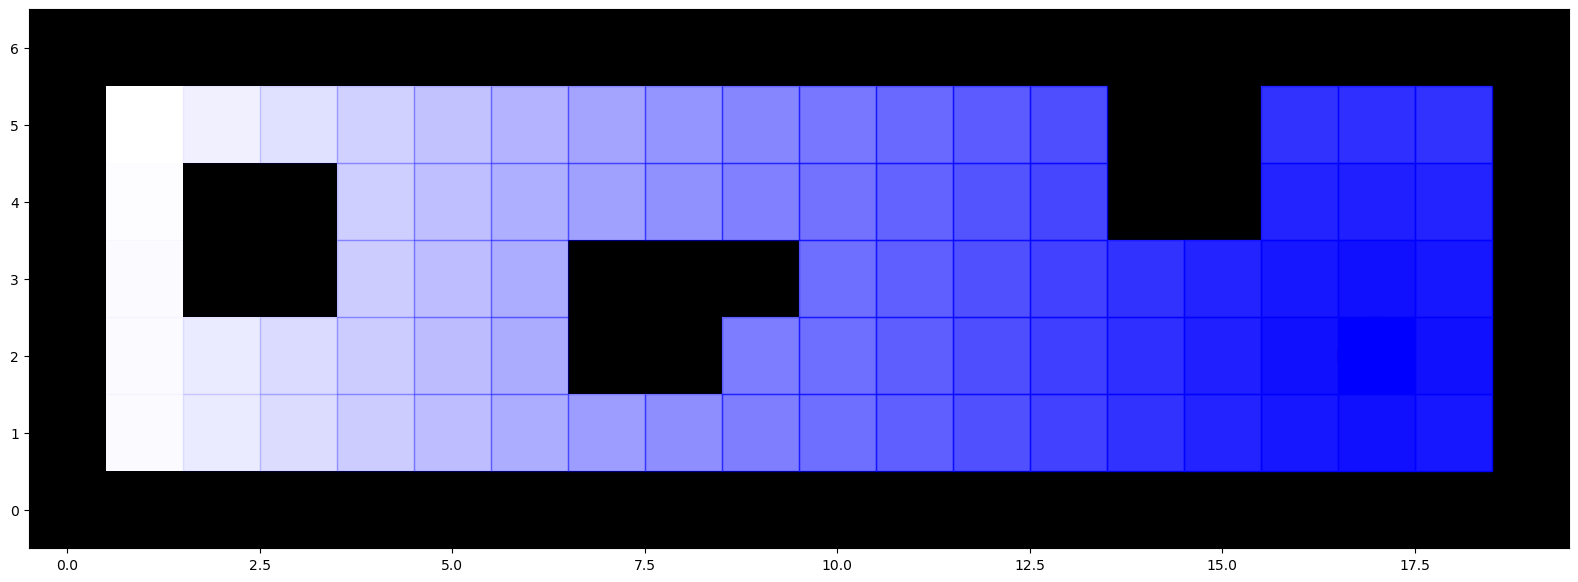

In [401]:
visualiza_recompensas()

Se puede diseñar una política ambiciosa o *greedy* que asigna a cada estado la acción que más acercaría el robot al objetivo (sin colisionar).

El siguiente código calcula dicha política y la devuelve como una lista de acciones, una por cada estado.

In [402]:
def crea_politica_greedy():
    p = []
    for e in nav_estados:
        valores = []
        for a in nav_acciones:
            e1 = aplica_accion(e,a)
            valores.append(obtiene_recompensa(e1))
        accion = nav_acciones[np.argmax(valores)]
        p.append(accion)
    return p
            
            

In [403]:
politica_greedy = crea_politica_greedy()
for p in zip (nav_estados,politica_greedy):
    print(p)

((0, 0), 'esperar')
((0, 1), 'esperar')
((0, 2), 'esperar')
((0, 3), 'esperar')
((0, 4), 'esperar')
((0, 5), 'esperar')
((0, 6), 'esperar')
((1, 0), 'esperar')
((1, 1), 'NE')
((1, 2), 'E')
((1, 3), 'SE')
((1, 4), 'NE')
((1, 5), 'E')
((1, 6), 'esperar')
((2, 0), 'esperar')
((2, 1), 'NE')
((2, 2), 'E')
((2, 3), 'esperar')
((2, 4), 'esperar')
((2, 5), 'E')
((2, 6), 'esperar')
((3, 0), 'esperar')
((3, 1), 'NE')
((3, 2), 'E')
((3, 3), 'esperar')
((3, 4), 'esperar')
((3, 5), 'SE')
((3, 6), 'esperar')
((4, 0), 'esperar')
((4, 1), 'NE')
((4, 2), 'E')
((4, 3), 'SE')
((4, 4), 'SE')
((4, 5), 'SE')
((4, 6), 'esperar')
((5, 0), 'esperar')
((5, 1), 'NE')
((5, 2), 'E')
((5, 3), 'SE')
((5, 4), 'SE')
((5, 5), 'SE')
((5, 6), 'esperar')
((6, 0), 'esperar')
((6, 1), 'E')
((6, 2), 'SE')
((6, 3), 'NE')
((6, 4), 'E')
((6, 5), 'SE')
((6, 6), 'esperar')
((7, 0), 'esperar')
((7, 1), 'E')
((7, 2), 'esperar')
((7, 3), 'esperar')
((7, 4), 'E')
((7, 5), 'SE')
((7, 6), 'esperar')
((8, 0), 'esperar')
((8, 1), 'NE')
(

La siguiente función realiza la visualización de una política

In [404]:
def visualiza_politica(politica):
    visualiza_mapa()
    for p in zip(nav_estados,politica):
        accion = p[1]
        if accion=='esperar':
            continue
        estado = p[0]
        e1 = aplica_accion(estado,accion)
        x0 = estado[0]
        y0 = estado[1]
        x1 = e1[0]
        y1 = e1[1]
        
        plt.gca().arrow(x0, y0, (x1 - x0)*0.6, (y1 - y0)*0.6,
         head_width=0.3, head_length=0.3, fc='black', ec='black')

    

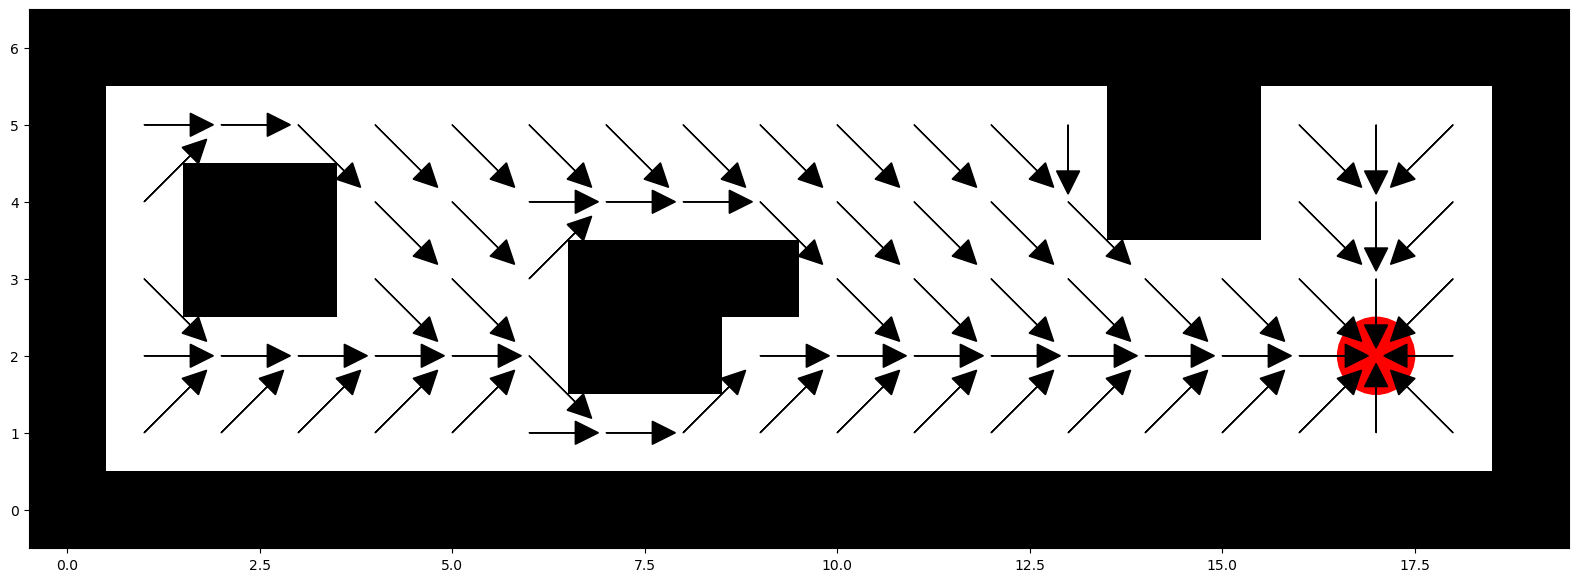

In [405]:
visualiza_politica(politica_greedy)

Obsérvese la presencia de óptimos locales

El siguiente código genera la matriz de recompensas SxA, en dónde:

* R(s,a) = -100 si *s* es un estado distinto del goal y *a* es *esperar*
* R(s,a) = R(s) en cualquier otro caso

In [406]:
def crea_recompensas_sistema():
    matriz = []
    for e in nav_estados:
        r = obtiene_recompensa(e)
        fila = [r]*len(nav_acciones)
        if e != destino:
            fila[0]=-100
        matriz.append(fila)
    return np.array(matriz)

In [407]:
nav_recompensas_sistema = crea_recompensas_sistema()

In [408]:
#Comento muchas lineas de esta celda porque debido a que el map2 es de menor dimensión produce errores.

#print(nav_estados[160])
print(nav_acciones)
#print(nav_recompensas_sistema[160,0])
#print(nav_recompensas_sistema[160,1])
#print(nav_recompensas_sistema[160,2])
#print(nav_recompensas_sistema[160,3])


['esperar', 'N', 'NE', 'E', 'SE', 'S', 'SO', 'O', 'NO']


In [409]:
nav_recompensas_sistema.shape

(140, 9)

El siguiente código obtiene el índice único de un estado a partir de sus coordenadas. El índice es la posición del estado en la lista de estados.

In [410]:
def obtiene_indice_estado(estado):
    return int(estado[0]*mapa.shape[0]+estado[1])

In [411]:
#Lo de arriba no es unico para el map2
print(destino)

(17.0, 2.0)


In [412]:
print(obtiene_indice_estado((10,7)))

77


Vamos a suponer que el movimiento del robot no es perfecto y puede desviarse a izquierda o derecha de su trayectoria, es decir:

* Si va en dirección N, podría terminar en dirección NE o NO
* Si va en dirección S, podría terminar en dirección SE o SO
* Si va en dirección E, podría terminar en dirección NE o SE
* Si va en dirección O, podría terminar en direcicón NO o SO
* Si va en dirección NE, podría terminar en dirección N o E
* Si va en dirección NO, podría terminar en dirección N u O
* Si va en dirección SE, podría terminar en dirección S o E
* Si va en dirección SO, podría terminar en dirección S u O

El siguiente código devuelve la lista de posibles acciones de error dada una acción. Téngase en cuenta, que la acción esperar no tiene error.

In [413]:
def obtiene_posibles_errores(accion):
    if accion=='N':
        errores = ['NE','NO']
    elif accion=='S':
        errores = ['SE','SO']
    elif accion=='E':
        errores = ['NE','SE']
    elif accion=='O':
        errores = ['NO', 'SO']
    elif accion=='NE':
        errores = ['N','E']
    elif accion=='NO':
        errores = ['N','O']
    elif accion=='SE':
        errores = ['S','E']
    elif accion == 'SO':
        errores = ['S','O']
    else:
        errores = []
    return errores

In [414]:
obtiene_posibles_errores('SE')

['S', 'E']

In [415]:
obtiene_posibles_errores('esperar')

[]

El siguiente código crea la matriz de transición SxS para una acción determinada y una probabilidad de error *prob_error*

* Con probabilidad *1 - prob_error*, el estado resultante será el correspondiente a aplicar la acción correctamente.
* Con probabilidad *prob_error/N*, el estado resultante será el correspondiente a aplicar una de las posibles acciones de error devueltas por la función anterior, en donde N es el número de acciones de error 

In [416]:
def crea_transiciones_movimiento(accion, prob_error):
    matriz = []
    for e0 in nav_estados:
        fila = [0]*len(nav_estados)
        if hay_colision(e0):
            fila[obtiene_indice_estado(e0)]=1
        else:
            goal = aplica_accion(e0,accion)
            errores = obtiene_posibles_errores(accion)
            if len(errores)==0:
                fila[obtiene_indice_estado(goal)] = 1
            else:
                fila[obtiene_indice_estado(goal)] = 1 - prob_error
                for error in errores:
                    goal_error = aplica_accion(e0,error)
                    fila[obtiene_indice_estado(goal_error)] = prob_error/len(errores)
        matriz.append(fila)
    return np.array(matriz)
       
            

In [417]:
test = crea_transiciones_movimiento('N',0.2)
print(test)
print(test[0,0])
print(test[obtiene_indice_estado((10,7)),obtiene_indice_estado((10,8))])
print(test[obtiene_indice_estado((10,7)),obtiene_indice_estado((9,8))])
print(test[obtiene_indice_estado((10,7)),obtiene_indice_estado((11,8))])

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
1.0
0.0
0.0
0.0


El siguiente código genera todas las transiciones del sistema como un array AxSxS

In [418]:
def crea_transiciones_sistema(prob_error):
    return np.array([crea_transiciones_movimiento('esperar',prob_error), 
                     crea_transiciones_movimiento('N',prob_error),
                     crea_transiciones_movimiento('NE',prob_error),
                     crea_transiciones_movimiento('E',prob_error),
                     crea_transiciones_movimiento('SE',prob_error),
                     crea_transiciones_movimiento('S',prob_error),
                     crea_transiciones_movimiento('SO',prob_error),
                     crea_transiciones_movimiento('O',prob_error),
                     crea_transiciones_movimiento('NO',prob_error)])

In [419]:
nav_transiciones_sistema = crea_transiciones_sistema(0.2)

In [420]:
nav_transiciones_sistema.shape

(9, 140, 140)

In [421]:
mapa.shape

(7, 20)

El siguiente diccionario devuelve el índice de una acción dado el nombre de la acción, será necesario porque los métodos de mdptoolbox utilizan índices para estados y acciones

In [422]:
indices_nav_acciones = {'esperar': 0, 'N': 1, 'NE': 2, 'E': 3, 'SE': 4, 'S': 5, 'SO': 6, 'O': 7, 'NO': 8}

El siguiente código traduce la política greedy a un array de índices de acciones, será la política por defecto que se utilizará en el agoritmo de Policy Iteration

In [423]:
politica_por_defecto = np.array([indices_nav_acciones[x] for x in politica_greedy])
politica_por_defecto

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 4, 2, 3, 0, 0, 2, 3, 0, 0, 3, 0, 0,
       2, 3, 0, 0, 4, 0, 0, 2, 3, 4, 4, 4, 0, 0, 2, 3, 4, 4, 4, 0, 0, 3,
       4, 2, 3, 4, 0, 0, 3, 0, 0, 3, 4, 0, 0, 2, 0, 0, 3, 4, 0, 0, 2, 3,
       0, 4, 4, 0, 0, 2, 3, 4, 4, 4, 0, 0, 2, 3, 4, 4, 4, 0, 0, 2, 3, 4,
       4, 4, 0, 0, 2, 3, 4, 4, 5, 0, 0, 2, 3, 4, 0, 0, 0, 0, 2, 3, 4, 0,
       0, 0, 0, 2, 3, 4, 4, 4, 0, 0, 1, 0, 5, 5, 5, 0, 0, 8, 7, 6, 6, 6,
       0, 0, 0, 0, 0, 0, 0, 0])

Ya estamos en condiones de plantear el problema como un MDP en mdptoolbox, utilizaremos el algoritmo Policy Iteration

In [424]:
import mdptoolbox.mdp as mdp
ejemplo_nav_robot = mdp.PolicyIteration(
    transitions=nav_transiciones_sistema,
    reward=nav_recompensas_sistema,
    discount=0.9,
    policy0=politica_por_defecto
)

Resolvemos el MDP

In [425]:
ejemplo_nav_robot.setVerbose()
ejemplo_nav_robot.run()


  Iteration		Number of different actions
    1		  27
    2		  16
    3		  3
    4		  0
Iterating stopped, unchanging policy found.


A continuación se muestra la acción para cada estado

In [426]:
for estado, i in zip(nav_estados, ejemplo_nav_robot.policy):
    print(f'En el estado {estado} ejecuta la acción {nav_acciones[i]}')

En el estado (0, 0) ejecuta la acción esperar
En el estado (0, 1) ejecuta la acción esperar
En el estado (0, 2) ejecuta la acción esperar
En el estado (0, 3) ejecuta la acción esperar
En el estado (0, 4) ejecuta la acción esperar
En el estado (0, 5) ejecuta la acción esperar
En el estado (0, 6) ejecuta la acción esperar
En el estado (1, 0) ejecuta la acción esperar
En el estado (1, 1) ejecuta la acción NE
En el estado (1, 2) ejecuta la acción SE
En el estado (1, 3) ejecuta la acción SE
En el estado (1, 4) ejecuta la acción S
En el estado (1, 5) ejecuta la acción E
En el estado (1, 6) ejecuta la acción esperar
En el estado (2, 0) ejecuta la acción esperar
En el estado (2, 1) ejecuta la acción NE
En el estado (2, 2) ejecuta la acción SE
En el estado (2, 3) ejecuta la acción esperar
En el estado (2, 4) ejecuta la acción esperar
En el estado (2, 5) ejecuta la acción E
En el estado (2, 6) ejecuta la acción esperar
En el estado (3, 0) ejecuta la acción esperar
En el estado (3, 1) ejecuta la 

Traducimos la política devuelta por el algoritmo a una lista de nombres de acciones, que es lo que requiere nuestro método de visualización

In [343]:
nav_politica = [nav_acciones[i] for i in ejemplo_nav_robot.policy]

Visualización de la política obtenida

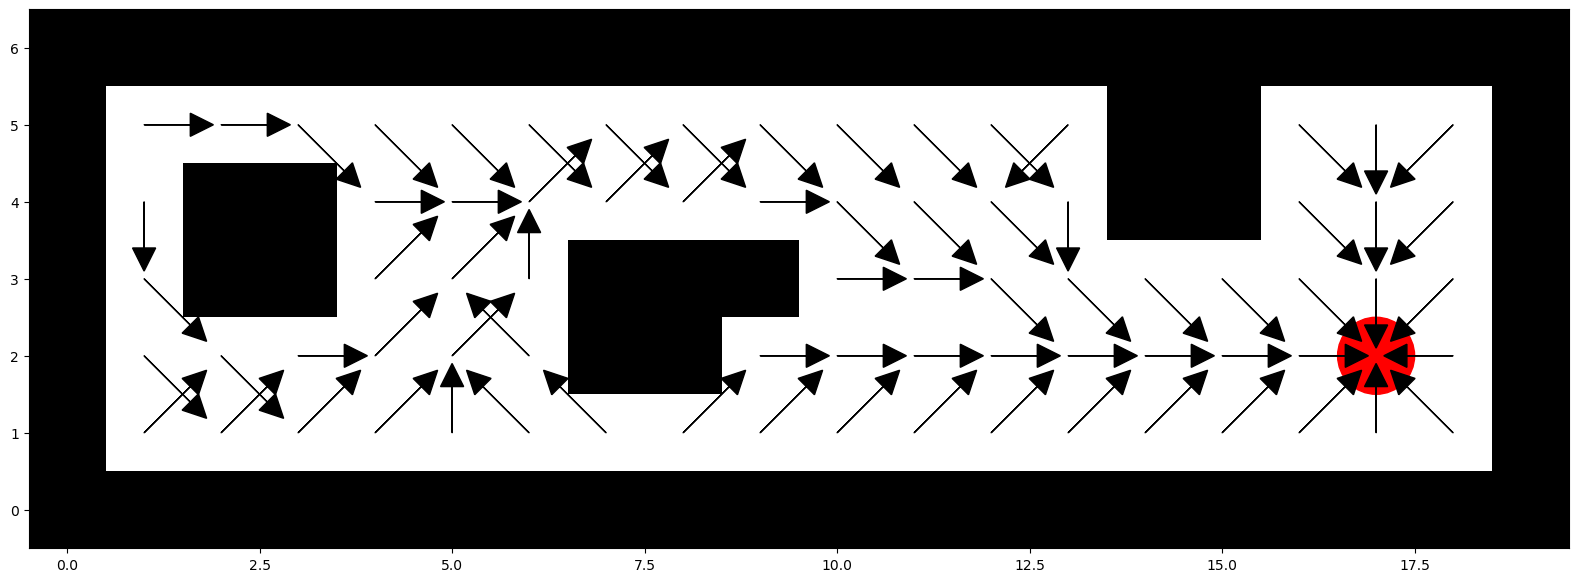

In [344]:
visualiza_politica(nav_politica)

Como se puede observar, no sólo se corrigen los óptimos locales con respecto a la política greedy, sino que el robot evita circular en el interior de corredores, en dónde la posibilidad de colisionar con una pared es superior.

In [345]:
# A continuación se encuentran implementados los algoritmos Montecarlo, SARSA y Q-Learning
# Además hay algunas funciones auxiliares las cuales usé para la implementación propia de Montecarlo y SARSA.
# También creé una función alternativa de recompensa.

In [346]:
#Implementado por mi (función alternativa de recompensa):
K = 1000
def obtiene_recompensa_2(estado):
    if hay_colision(estado):
        valor = -K
    elif estado != destino:
        valor = -1
    else:
        valor = 0
    return valor

In [347]:
# La siguiente función la utilizo para calcular la secuencia inicial requerida tanto en montecarlo como en SARSA

def aplica_accion_porcentaje_error(estado,accion,error):
    if(error > 1 or error < 0):
        raise Exception("El porcentaje de error debe estar entre 0 y 1.")
    random = np.random.rand()
    errors = obtiene_posibles_errores(accion)
    success = 1 - error
    if len(errors) != 0:
        if random < success:
            return aplica_accion(estado,accion)
        elif random < (success + error/2):
            return aplica_accion(estado,errors[0])
        else:
            return aplica_accion(estado,errors[1])
            
    else:
        return aplica_accion(estado,accion)
        
        

In [348]:
# La siguiente función calcula y devuelve la secuencia inicial necesaria para el algoritmo de Montecarlo y SARSA
# Tiene un parámetro boolean montecarlo, que si está en True toma una primera accion aleatoria en la secuencia y si está en false
# toma como primera acción la que indique la política para el primer estado.

def crear_secuencia_inicial(politica , montecarlo):
    max_iter= 500
    while True:
        e0 =  nav_estados[np.random.randint(0, len(nav_estados))]
        if montecarlo == True:
            a0 = nav_acciones[np.random.randint(0, len(nav_acciones))]
        else:
            a0 = politica[obtiene_indice_estado(e0)]
        e1= aplica_accion_porcentaje_error(e0,a0,0.2)
        estados = []
        acciones = []
        iterations = 0
        while(hay_colision(e0) or hay_colision(e1)):
            e0 =  nav_estados[np.random.randint(0, len(nav_estados))]
            a0 = nav_acciones[np.random.randint(0, len(nav_acciones))]
            e1= aplica_accion(e0,a0)
        estados.append(e0)
        estados.append(e1)
        acciones.append(a0)
    
        while(e1 != destino):
            accion = politica[obtiene_indice_estado(e1)]
            e1 = aplica_accion_porcentaje_error(e1,accion,0.2)
            estados.append(e1)
            acciones.append(accion)
            iterations +=1
            if(hay_colision(e1)):
                break
            if iterations >= max_iter:
                break


        if(e1 == destino):
            break

    return [estados,acciones]

In [349]:
#Implementación montecarlo

In [350]:
def montecarlo(politica_inicial, n_iteraciones, discount, primera_visita):
    politica_res = politica_inicial.copy()
    Racum = {}
    q_values = {}
    acum = {}

    for e in nav_estados:
        if not (hay_colision(e)):
            for a in nav_acciones:
                if e not in acum: 
                    acum[e] = []
                acum[e].append((0,a))
    
    for k in range(n_iteraciones):
        sec_inicial = crear_secuencia_inicial(politica_res , True)
        control_seq = []
        estados_secuencia = sec_inicial[0]
        acciones_secuencia = sec_inicial[1]
        for i in range(len(acciones_secuencia)):
            if primera_visita== False or (primera_visita== True and ( (estados_secuencia[i], acciones_secuencia[i]) not in control_seq)):
                control_seq.append((estados_secuencia[i], acciones_secuencia[i]))
                utility = 0
                if (estados_secuencia[i], acciones_secuencia[i]) not in Racum:
                    Racum[(estados_secuencia[i], acciones_secuencia[i])] = []
                for j in range(i, len(estados_secuencia)):
                    utility += (discount**(j-i) * obtiene_recompensa_2(estados_secuencia[j]))
                Racum[(estados_secuencia[i], acciones_secuencia[i])].append(utility)
                q_values[(estados_secuencia[i], acciones_secuencia[i])] = np.mean(Racum[(estados_secuencia[i], acciones_secuencia[i])])
                acum[estados_secuencia[i]].append((q_values[(estados_secuencia[i], acciones_secuencia[i])] , acciones_secuencia[i]))
                array_acum = np.array(acum[estados_secuencia[i]])
                index = np.argmax(array_acum[:, 0])
                politica_res[obtiene_indice_estado(estados_secuencia[i])] = acum[estados_secuencia[i]][index][1]
    
    return politica_res

In [351]:
#Test del algoritmo de montecarlo que nos devuelve la política óptima calculada, en este caso ,  tras 1000 iteraciones. 
politica_greedy2 = crea_politica_greedy()
test_montecarlo_primera_visita = montecarlo( politica_inicial = politica_greedy2, n_iteraciones = 1000, discount = 0.9, primera_visita = True)

In [352]:
for estado, accion in zip(nav_estados, test_montecarlo_primera_visita):
    print(f'En el estado {estado} ejecuta la acción {accion}')

En el estado (0, 0) ejecuta la acción esperar
En el estado (0, 1) ejecuta la acción esperar
En el estado (0, 2) ejecuta la acción esperar
En el estado (0, 3) ejecuta la acción esperar
En el estado (0, 4) ejecuta la acción esperar
En el estado (0, 5) ejecuta la acción esperar
En el estado (0, 6) ejecuta la acción esperar
En el estado (1, 0) ejecuta la acción esperar
En el estado (1, 1) ejecuta la acción NE
En el estado (1, 2) ejecuta la acción E
En el estado (1, 3) ejecuta la acción SE
En el estado (1, 4) ejecuta la acción NE
En el estado (1, 5) ejecuta la acción E
En el estado (1, 6) ejecuta la acción esperar
En el estado (2, 0) ejecuta la acción esperar
En el estado (2, 1) ejecuta la acción NE
En el estado (2, 2) ejecuta la acción E
En el estado (2, 3) ejecuta la acción esperar
En el estado (2, 4) ejecuta la acción esperar
En el estado (2, 5) ejecuta la acción E
En el estado (2, 6) ejecuta la acción esperar
En el estado (3, 0) ejecuta la acción esperar
En el estado (3, 1) ejecuta la a

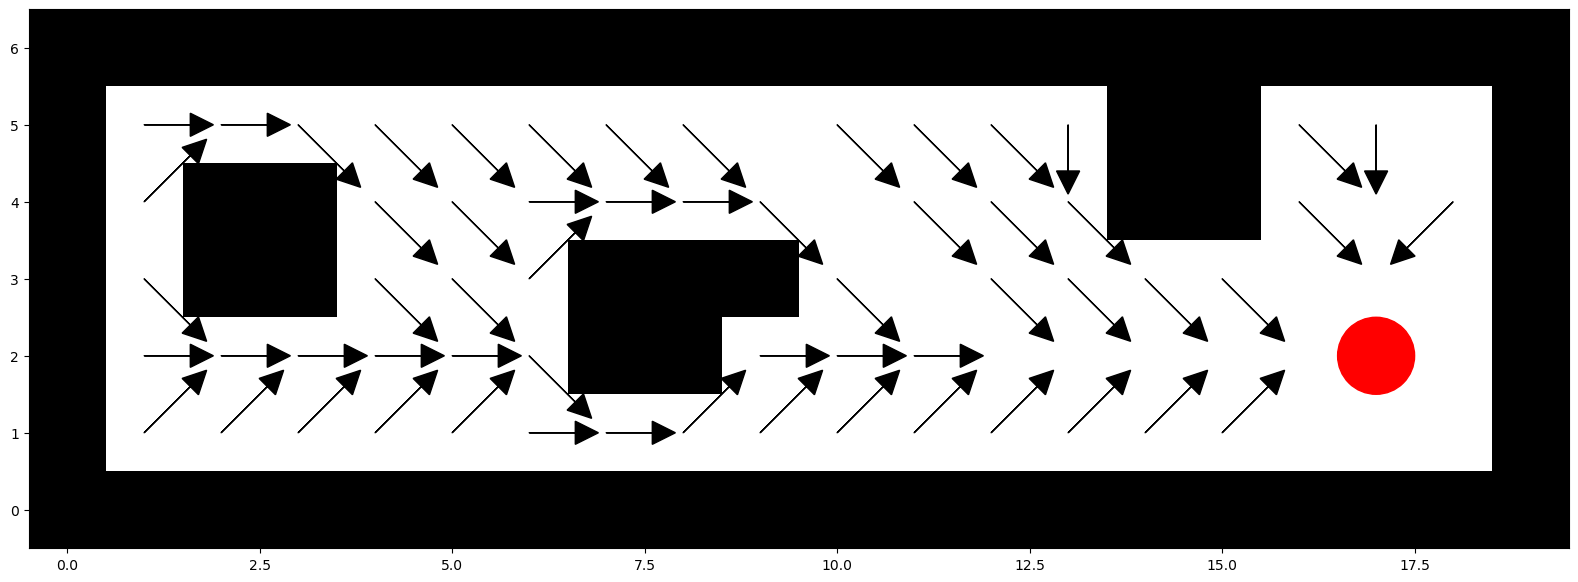

In [353]:
visualiza_politica(test_montecarlo_primera_visita)

In [354]:
#Test del algoritmo de montecarlo que nos devuelve la política óptima calculada, en este caso ,  tras 1000 iteraciones. 
politica_greedy2 = crea_politica_greedy()
test_montecarlo_cada_visita = montecarlo( politica_inicial = politica_greedy2, n_iteraciones = 1000, discount = 0.9, primera_visita = False)

In [355]:
for estado, accion in zip(nav_estados, test_montecarlo_cada_visita):
    print(f'En el estado {estado} ejecuta la acción {accion}')

En el estado (0, 0) ejecuta la acción esperar
En el estado (0, 1) ejecuta la acción esperar
En el estado (0, 2) ejecuta la acción esperar
En el estado (0, 3) ejecuta la acción esperar
En el estado (0, 4) ejecuta la acción esperar
En el estado (0, 5) ejecuta la acción esperar
En el estado (0, 6) ejecuta la acción esperar
En el estado (1, 0) ejecuta la acción esperar
En el estado (1, 1) ejecuta la acción NE
En el estado (1, 2) ejecuta la acción E
En el estado (1, 3) ejecuta la acción esperar
En el estado (1, 4) ejecuta la acción NE
En el estado (1, 5) ejecuta la acción E
En el estado (1, 6) ejecuta la acción esperar
En el estado (2, 0) ejecuta la acción esperar
En el estado (2, 1) ejecuta la acción NE
En el estado (2, 2) ejecuta la acción esperar
En el estado (2, 3) ejecuta la acción esperar
En el estado (2, 4) ejecuta la acción esperar
En el estado (2, 5) ejecuta la acción E
En el estado (2, 6) ejecuta la acción esperar
En el estado (3, 0) ejecuta la acción esperar
En el estado (3, 1) e

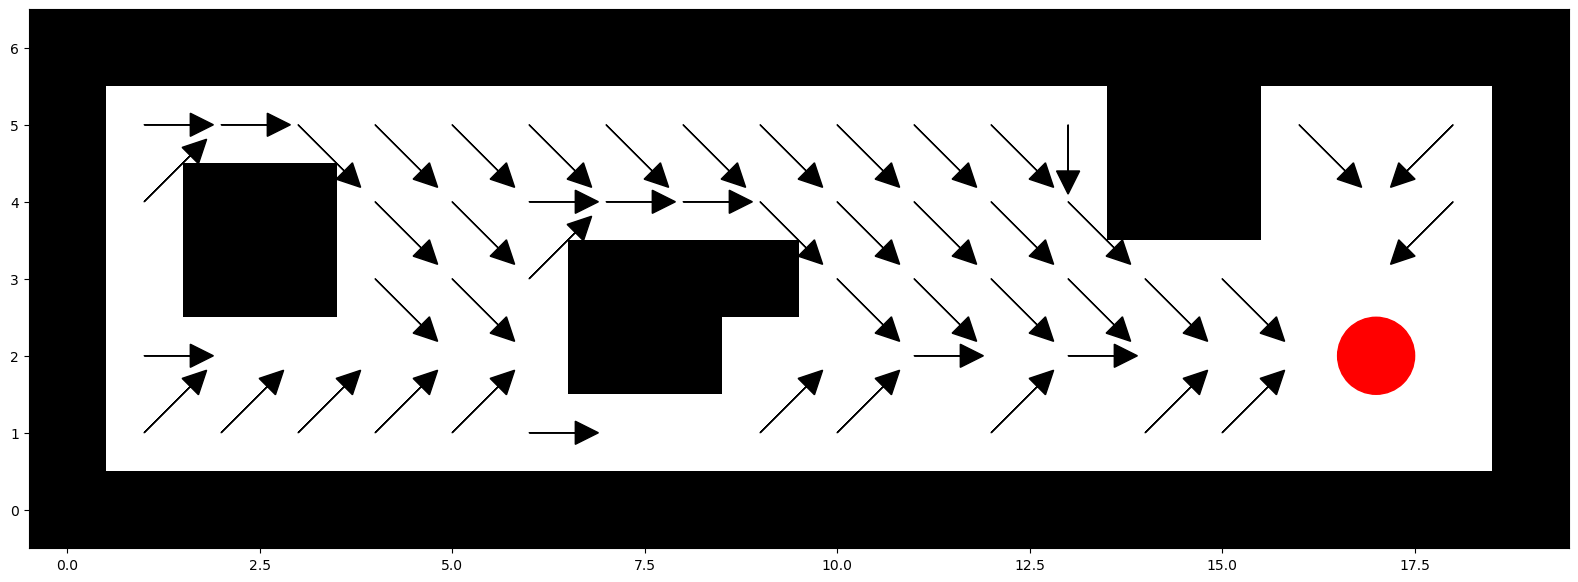

In [356]:
visualiza_politica(test_montecarlo_cada_visita)

In [357]:
# Implementación SARSA
def SARSA(politica_inicial, n_iteraciones, discount, learning):
    politica_res = politica_inicial.copy()
    q_values = {}
    acum = {}
    for e in nav_estados:
            for a in nav_acciones:
                q_values[(e,a)] = 0
                if e not in acum: 
                    acum[e] = []
                acum[e].append((0,a))

    for k in range(n_iteraciones):
        sec_inicial = crear_secuencia_inicial(politica_res, False)
        estados_secuencia = sec_inicial[0]
        acciones_secuencia = sec_inicial[1] 
        for i in range(len(acciones_secuencia)):
            estado_actual = estados_secuencia[i]
            accion_actual = acciones_secuencia[i]
            estado_siguiente = estados_secuencia[i+1]
            accion_siguiente = politica_res[obtiene_indice_estado(estado_siguiente)]
            reward = obtiene_recompensa(estado_siguiente)
            q_values[(estado_actual,accion_actual)] += learning * (reward + (discount* q_values[(estado_siguiente,accion_siguiente)]) - q_values[(estado_actual,accion_actual)])
            acum[estado_actual].append((q_values[(estado_actual,accion_actual)] , accion_actual))
            array_acum = np.array(acum[estado_actual])
            index = np.argmax(array_acum[:, 0])
            politica_res[obtiene_indice_estado(estado_actual)] = acum[estado_actual][index][1]

    return politica_res
            

In [372]:
#Test del algoritmo SARSA que nos devuelve la política óptima calculada, en este caso ,  tras 1000 iteraciones , con factor de
# descuento 0.9 y de aprendizaje 0.5

politica_greedy3 = crea_politica_greedy()
test_SARSA = SARSA (politica_inicial = politica_greedy3, n_iteraciones = 1000, discount = 0.9, learning = 0.5)

In [373]:
for estado, accion in zip(nav_estados, test_SARSA):
    print(f'En el estado {estado} ejecuta la acción {accion}')

En el estado (0, 0) ejecuta la acción esperar
En el estado (0, 1) ejecuta la acción esperar
En el estado (0, 2) ejecuta la acción esperar
En el estado (0, 3) ejecuta la acción esperar
En el estado (0, 4) ejecuta la acción esperar
En el estado (0, 5) ejecuta la acción esperar
En el estado (0, 6) ejecuta la acción esperar
En el estado (1, 0) ejecuta la acción esperar
En el estado (1, 1) ejecuta la acción NE
En el estado (1, 2) ejecuta la acción E
En el estado (1, 3) ejecuta la acción SE
En el estado (1, 4) ejecuta la acción NE
En el estado (1, 5) ejecuta la acción E
En el estado (1, 6) ejecuta la acción esperar
En el estado (2, 0) ejecuta la acción esperar
En el estado (2, 1) ejecuta la acción NE
En el estado (2, 2) ejecuta la acción E
En el estado (2, 3) ejecuta la acción esperar
En el estado (2, 4) ejecuta la acción esperar
En el estado (2, 5) ejecuta la acción E
En el estado (2, 6) ejecuta la acción esperar
En el estado (3, 0) ejecuta la acción esperar
En el estado (3, 1) ejecuta la a

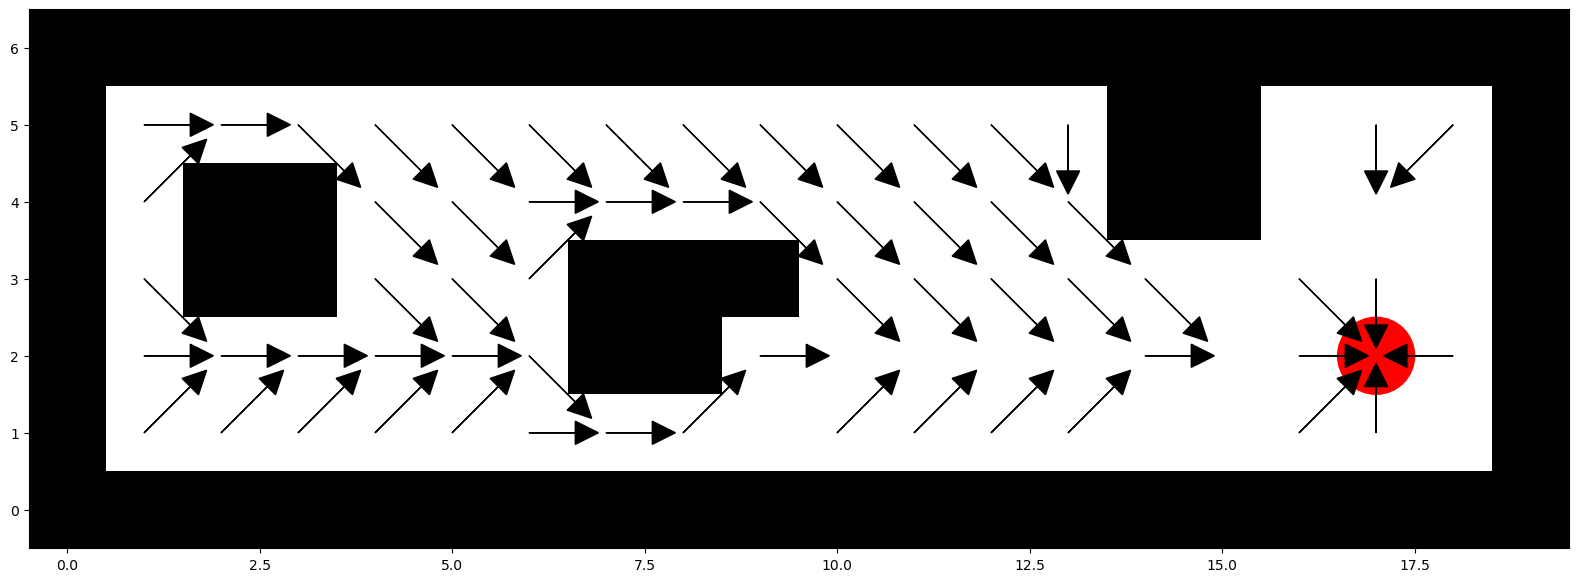

In [374]:
visualiza_politica(test_SARSA)

In [361]:
#Resolucion con Q-Learning

In [437]:
#Uso la biblioteca mdp y paso como parametro a la funcion las transicciones y recompensas del sistema, asi como un factor de
# descuento 0.9 y un número de iteraciones = 10000
ejemplo_nav_robot_ql = mdp.QLearning(
    transitions=nav_transiciones_sistema,
    reward=nav_recompensas_sistema,
    n_iter=100000,
    discount=0.9
)

In [438]:
ejemplo_nav_robot_ql.run()


In [439]:
for estado, i in zip(nav_estados, ejemplo_nav_robot_ql.policy):
    print(f'En el estado {estado} ejecuta la acción {nav_acciones[i]}')

En el estado (0, 0) ejecuta la acción esperar
En el estado (0, 1) ejecuta la acción esperar
En el estado (0, 2) ejecuta la acción NO
En el estado (0, 3) ejecuta la acción O
En el estado (0, 4) ejecuta la acción esperar
En el estado (0, 5) ejecuta la acción esperar
En el estado (0, 6) ejecuta la acción esperar
En el estado (1, 0) ejecuta la acción SO
En el estado (1, 1) ejecuta la acción NE
En el estado (1, 2) ejecuta la acción SO
En el estado (1, 3) ejecuta la acción NE
En el estado (1, 4) ejecuta la acción SE
En el estado (1, 5) ejecuta la acción S
En el estado (1, 6) ejecuta la acción esperar
En el estado (2, 0) ejecuta la acción esperar
En el estado (2, 1) ejecuta la acción NO
En el estado (2, 2) ejecuta la acción O
En el estado (2, 3) ejecuta la acción esperar
En el estado (2, 4) ejecuta la acción N
En el estado (2, 5) ejecuta la acción E
En el estado (2, 6) ejecuta la acción esperar
En el estado (3, 0) ejecuta la acción esperar
En el estado (3, 1) ejecuta la acción NO
En el estado

In [440]:
nav_politica_ql = [nav_acciones[i] for i in ejemplo_nav_robot_ql.policy]

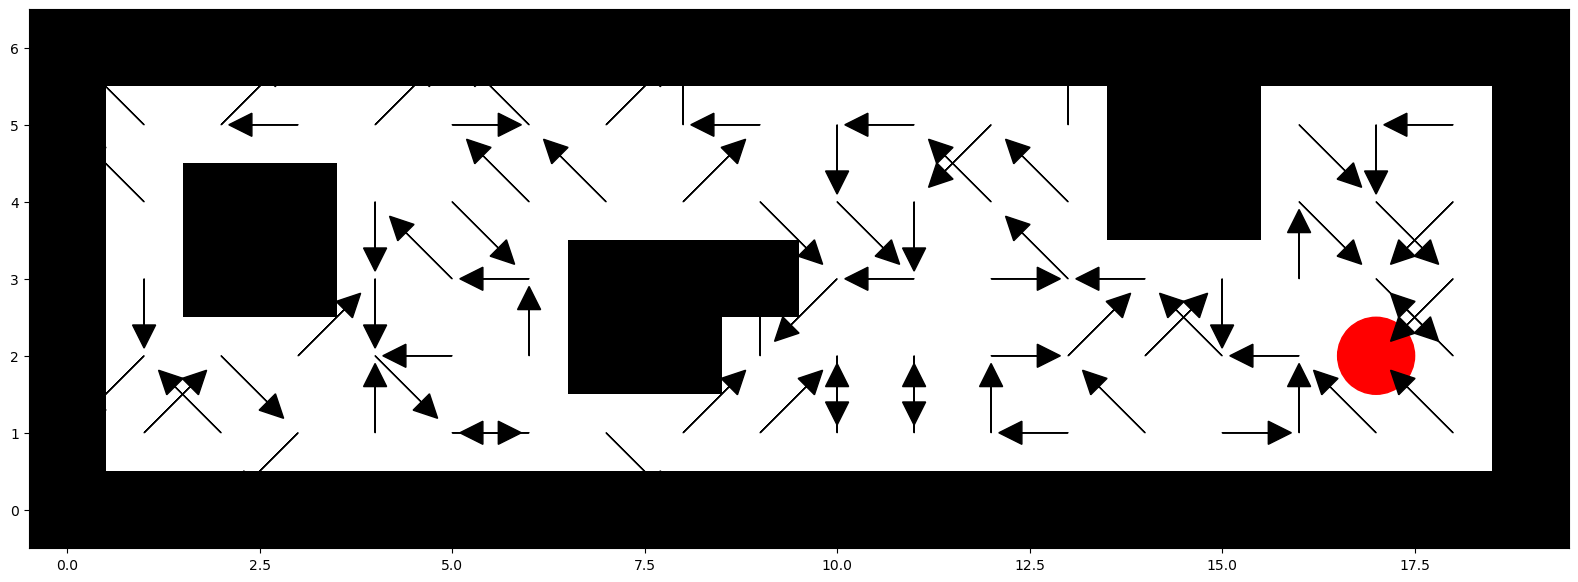

In [436]:
visualiza_politica(nav_politica_ql)